# Spatial Data & Inequality_WeDSS Walkthrough

This walkthrough will provide an in-depth exploration of the steps taken to :
1. Identify governorates' boundaries
2. Extract POIs
3. Cleaning the data for EDA and further analysis

In [21]:
# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import math
import json
import os
from scipy import stats
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import re


## Section 1 : Identifying Boundaries

Step 1:
We acquired the boundaries for the Admin 2 regions through OCHA & CAPMAS dataset found through: https://data.humdata.org/dataset/cod-ab-egy 

Step 2:
Using the polygons provided in the data above, we transformed it into squares to prep for the Google Places API. 


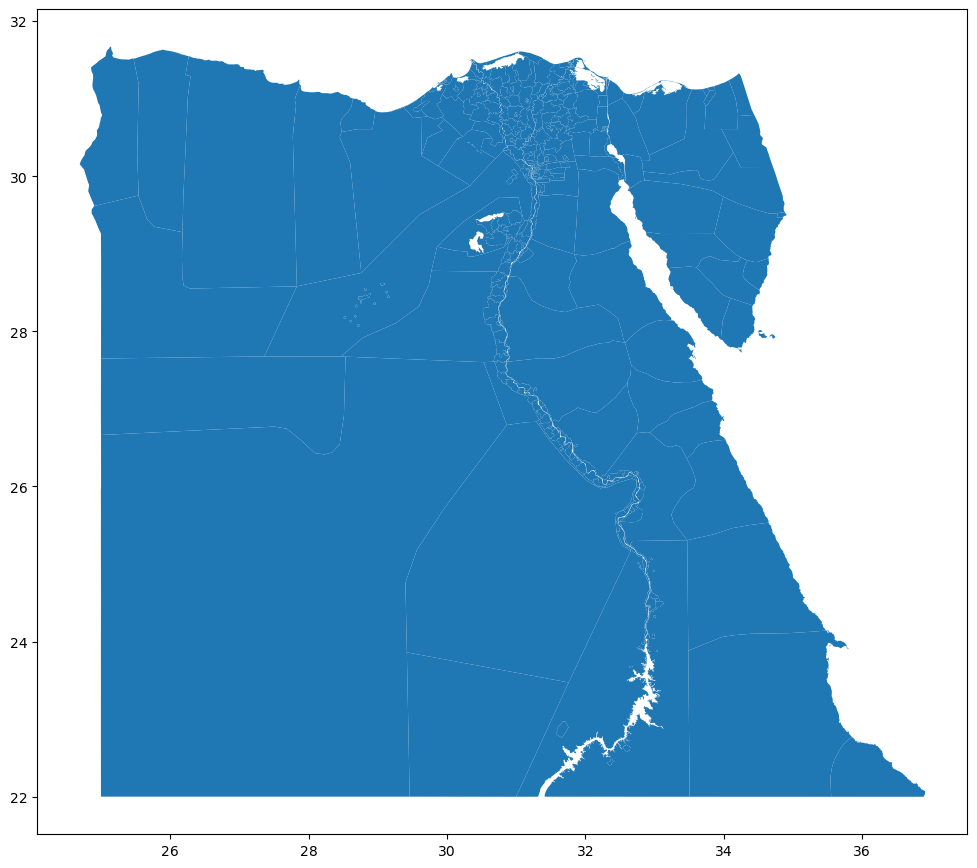

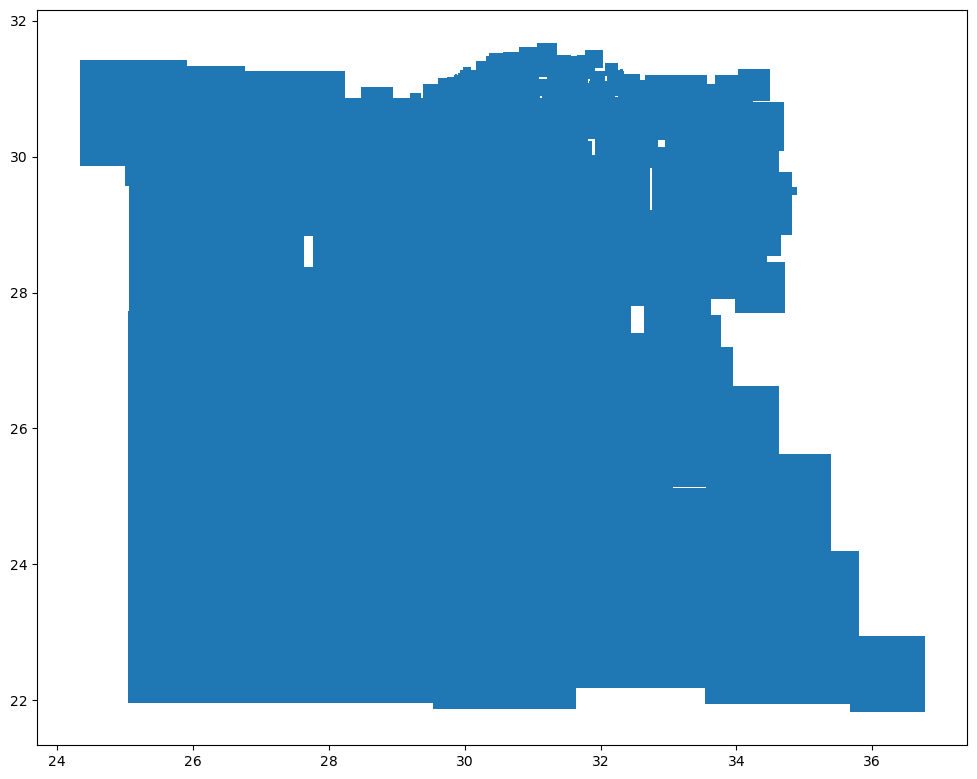

In [2]:
# Code built by Nour Abdelbaki

wd_file = 'egy_admbnda_adm2_capmas_20170421\egy_admbnda_adm2_capmas_20170421.shp'

gdf = gpd.read_file(wd_file,
                    encoding='UTF-8')

f, axes = plt.subplots(1, figsize=(12, 12))
axes = gdf.plot(ax=axes)
plt.show()

#### makes an exact square ####
def to_square(polygon):
    '''
    This function takes a polygon and returns a square that has the same centroid
    and the same diagonal as the polygon.
    Input: 
        polygon: a shapely Polygon object
    Returns:
        a shapely object that is a square
    '''
    # unpacking the polygon's bounds
    minx, miny, maxx, maxy = polygon.bounds
    
    # getting the centroid
    centroid = [(maxx+minx)/2, (maxy+miny)/2]
    # getting the diagonal
    diagonal = math.sqrt((maxx-minx)**2+(maxy-miny)**2)
    
    # creating the square
    return Point(centroid).buffer(diagonal/math.sqrt(2.)/2., cap_style=3)

gdf['squares'] = gdf['geometry'].map(to_square)


f, axes = plt.subplots(1, figsize=(12, 12))
axes = gdf['squares'].plot(ax=axes)
plt.show()

data_list = []
for index, row in gdf.iterrows():
  data_list.append({'ADM2': row['ADM2_AR'],
    'ADM1': row['ADM1_AR'], 
    'lat_range':[row['squares'].bounds[1], row['squares'].bounds[3]],
    'long_range':[row['squares'].bounds[0], row['squares'].bounds[2]]})

with open('all_admin2_boundaries.json', 'w', encoding='utf-8') as outfile:
   json.dump(data_list, outfile, ensure_ascii=False)

Step 3:
We picked out the boundaries of interest from the generated boundaries above based on the list of poorest villages provided by the government and comparable counterparts (usually the capital of the governorates). The final dataset is already attached.


## Section 2 Data Extraaction
As Google Maps API limits the number 
of places returned per query to 60, we 
divided constituencies into circles, 
enabling us to recursively call the API in 
this boundary to scrape everything 
without the 60 responses limit.

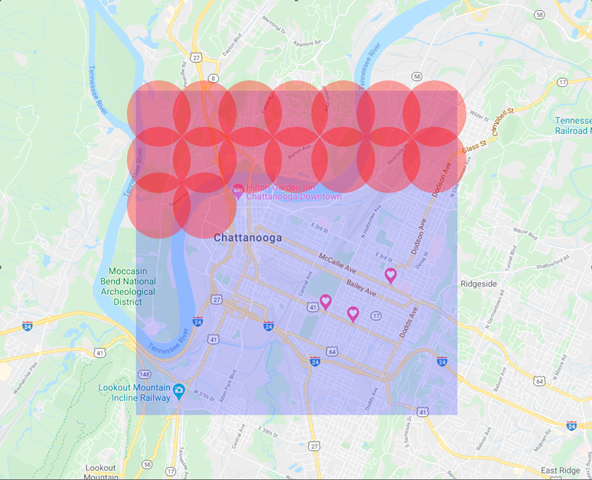

Step 1 :  
* Navigate to argo_automated and set working directory use the following in Terminal  cd "C:\spatial-wealth-distribution\argo_automated\src"

Step 2:

*   Open config.json 
    * Change POI terms and radius 
    * Everything else is fed directly from "boundaries_interest.json"

Step 3:

* Run index.js 

Step 4 :

*   Once Index.js is fully finished and the final region appears in “out”:
    * Navigate to Config and repeat step 3 until all POIs are done.


Step 5 :
* Refer to "Renaming.py" and “Combiner.py” to combine datasets into a single dataset.
    *	Manually classify each POI returned into the most appropriated category




## Section 3 : Processing and EDA
We conducted hypothesis testing for whether there is a significant difference between the mean count of the POI in poor Marakez and non-poor Marakez (unweighted), and also whether there is a significant difference between the mean count of the POI in poor Marakez and non-poor Marakez (weighted by population). 
All Maps included in the presentation are made through Kepler.gl. Please note that certain maps might require the addition of certain columns in the datasets.



### 3.1 : Processing 

In [37]:
# Specify the path to the main directory

main_directory = ".\out"

# Get all folders in the main directory

all_governorates = []
# Loop through all the folders in the main directory and save folder paths in a list
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    all_governorates.append(folder_path)

In [38]:
all_governorates = all_governorates[0:4] + all_governorates[5:]
all_governorates

['.\\out\\output_قسم  برج العرب',
 '.\\out\\output_قسم غرب النوبارية',
 '.\\out\\output_مركز أبو طشت',
 '.\\out\\output_مركز أبوتيج',
 '.\\out\\output_مركز أسوان',
 '.\\out\\output_مركز أسيوط',
 '.\\out\\output_مركز أطفيح',
 '.\\out\\output_مركز إمبابة',
 '.\\out\\output_مركز ابوالمطامير',
 '.\\out\\output_مركز الأقصر',
 '.\\out\\output_مركز البلينا',
 '.\\out\\output_مركز الجيزة',
 '.\\out\\output_مركز الحسينية',
 '.\\out\\output_مركز الزقازيق',
 '.\\out\\output_مركز العدوة',
 '.\\out\\output_مركز الفشن',
 '.\\out\\output_مركز المنصورة',
 '.\\out\\output_مركز المنيا',
 '.\\out\\output_مركز ببا',
 '.\\out\\output_مركز بلقاس',
 '.\\out\\output_مركز بنى سويف',
 '.\\out\\output_مركز جرجا',
 '.\\out\\output_مركز دشنا',
 '.\\out\\output_مركز دمنهور',
 '.\\out\\output_مركز ديروط',
 '.\\out\\output_مركز سوهاج',
 '.\\out\\output_مركز قنا',
 '.\\out\\output_مركز ملوى']

In [51]:
output_text

'output_مركز ملوى\\output_مركز ملوى_poi_منفذ بيع'

In [76]:
# For each folder, there is a folder for each POI, 
# and each POI folder contains a CSV file with the data

output_pattern = re.compile(r'output_([^\\]+)')
poi_pattern = re.compile(r'poi_([^_]+)')

# Initialize an empty dictionary to store the results
results = {}

# Loop through all the folders in the main directory
for folder in all_governorates:
    for subfolder in os.listdir(folder):
        folder_path = os.path.join(folder, subfolder)

        output_match = output_pattern.search(folder_path)
        poi_match = poi_pattern.search(folder_path)
        
        if output_match and poi_match:
            output_text = output_match.group(1)
            poi_text = poi_match.group(1)
            
            # Find the CSV file in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".csv"):
                    csv_path = os.path.join(folder_path, file_name)
                    
                    # Read the CSV file
                    df = pd.read_csv(csv_path)
                    
                    # Count the number of rows in the CSV file
                    row_count = len(df)

                    # Append the extracted information into the dictionary
                    results[(output_text, poi_text)] = row_count
# print the results
                    
results

{('قسم  برج العرب', 'تموين'): 9,
 ('قسم  برج العرب', 'مدرسة'): 284,
 ('قسم  برج العرب', 'مركز شباب'): 22,
 ('قسم  برج العرب', 'مستشفى'): 89,
 ('قسم  برج العرب', 'منفذ بيع'): 18,
 ('قسم غرب النوبارية', 'تموين'): 3,
 ('قسم غرب النوبارية', 'مدرسة'): 131,
 ('قسم غرب النوبارية', 'مركز شباب'): 14,
 ('قسم غرب النوبارية', 'مستشفى'): 26,
 ('قسم غرب النوبارية', 'منفذ بيع'): 6,
 ('مركز أبو طشت', 'تموين'): 12,
 ('مركز أبو طشت', 'مدرسة'): 419,
 ('مركز أبو طشت', 'مركز شباب'): 25,
 ('مركز أبو طشت', 'مستشفى'): 81,
 ('مركز أبو طشت', 'منفذ بيع'): 2,
 ('مركز أبوتيج', 'تموين'): 23,
 ('مركز أبوتيج', 'مدرسة'): 323,
 ('مركز أبوتيج', 'مركز شباب'): 19,
 ('مركز أبوتيج', 'مستشفى'): 48,
 ('مركز أبوتيج', 'منفذ بيع'): 1,
 ('مركز أسوان', 'تموين'): 12,
 ('مركز أسوان', 'مدرسة'): 250,
 ('مركز أسوان', 'مركز شباب'): 33,
 ('مركز أسوان', 'مستشفى'): 94,
 ('مركز أسوان', 'منفذ بيع'): 6,
 ('مركز أسيوط', 'تموين'): 54,
 ('مركز أسيوط', 'مدرسة'): 753,
 ('مركز أسيوط', 'مركز شباب'): 67,
 ('مركز أسيوط', 'مستشفى'): 203,
 ('مركز أسيوط'

In [78]:
pois = set(key[1] for key in results.keys())

for poi in pois:
    if poi == 'مستشفى': 
        hospital = \
            {key[0]: value for key, value in results.items() if key[1] == poi}
    elif poi == 'مدرسة':
        school = \
            {key[0]: value for key, value in results.items() if key[1] == poi}    
    elif poi == 'تموين':
        subsidized_goods = \
            {key[0]: value for key, value in results.items() if key[1] == poi}
    elif poi == 'مركز شباب':
        youth_center = \
            {key[0]: value for key, value in results.items() if key[1] == poi}  
    elif poi == 'منفذ بيع':
        retail_outlet = \
            {key[0]: value for key, value in results.items() if key[1] == poi}


In [85]:
# Create a list of the names of the identified poorest marakez that are in 
# the pilot 

poor_marakez = ['مركز ديروط', 'قسم  برج العرب', 'مركز الفشن',
'مركز ملوى', 'مركز سوهاج', 'مركز أدفو', 'مركز ابوالمطامير',
'مركز أطفيح', 'مركز بلقاس', 'مركز أبو طشت', 'مركز البلينا', 'مركز العدوة',
'مركز أبوتيج', 'مركز ببا', 'مركز جرجا', 'قسم غرب النوبارية', 'مركز إمبابة', 
'مركز الحسينية', 'مركز دشنا']

In [86]:
# Preping for Mean testing

# hospitals
df_hospital = pd.DataFrame(hospital.items(), columns=['Markaz', 'Count'])
df_hospital['poor'] = df_hospital['Markaz'].isin(poor_marakez)

# schools
df_school = pd.DataFrame(school.items(), columns=['Markaz', 'Count'])
df_school['poor'] = df_school['Markaz'].isin(poor_marakez)

# subsidized_goods
df_subsidized = pd.DataFrame(subsidized_goods.items(), columns=['Markaz', 'Count'])
df_subsidized['poor'] = df_subsidized['Markaz'].isin(poor_marakez)

# youth_center
df_youth_center = pd.DataFrame(youth_center.items(), columns=['Markaz', 'Count'])
df_youth_center['poor'] = df_youth_center['Markaz'].isin(poor_marakez)

# retail_outlet
df_retail_outlet = pd.DataFrame(retail_outlet.items(), columns=['Markaz', 'Count'])
df_retail_outlet['poor'] = df_retail_outlet['Markaz'].isin(poor_marakez)

In [82]:
df_hospital[df_hospital['poor']]['Count'].count()

18

In [83]:
df_hospital[~df_hospital['poor']]['Count'].count()

10

### Section 3.2 : EDA

### Section 3.2.1 : Hospitals

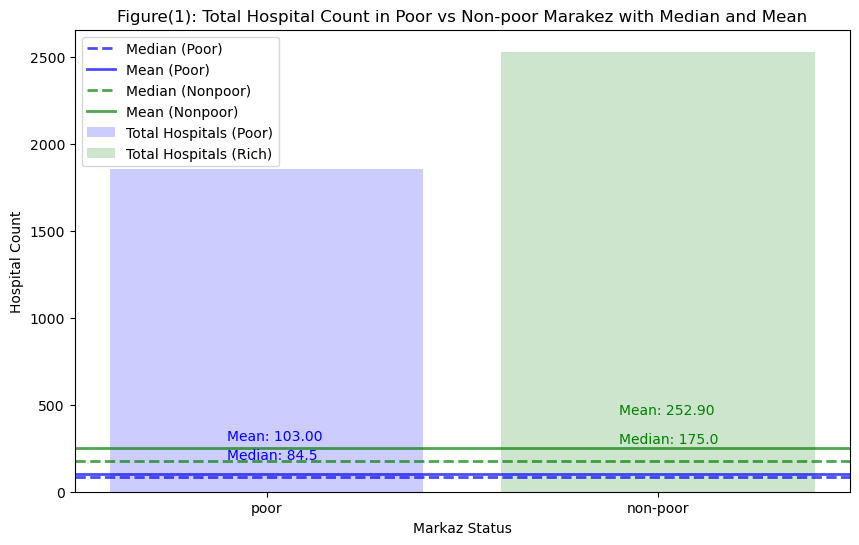

In [87]:
# Aggregate the data to get the total, median, and average count of hospitals in poor and rich marakez
hospital_grouped = df_hospital.groupby('poor')['Count'].agg(['sum', 'median', 'mean']).reset_index()

# Calculate the median and mean for each markaz type
median_poor = df_hospital[df_hospital['poor']]['Count'].median()
median_rich = df_hospital[~df_hospital['poor']]['Count'].median()
mean_poor = df_hospital[df_hospital['poor']]['Count'].mean()
mean_rich = df_hospital[~df_hospital['poor']]['Count'].mean()

# Visualize the data using a bar plot and add the median and average lines
plt.figure(figsize=(10, 6))
#plt.bar(hospital_grouped['poor'], hospital_grouped['sum'], color=['blue', 'green'], alpha=0.2)

bar_poor = plt.bar('poor', hospital_grouped.loc[hospital_grouped['poor'] == True, 'sum'], color='blue', alpha=0.2, label='Total Hospitals (Poor)')
bar_rich = plt.bar('non-poor', hospital_grouped.loc[hospital_grouped['poor'] == False, 'sum'], color='green', alpha=0.2, label='Total Hospitals (Rich)')

# Add horizontal lines for median and mean with reduced opacity
plt.axhline(y=median_poor, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Median (Poor)')
plt.axhline(y=mean_poor, color='blue', linestyle='-', linewidth=2, alpha=0.7, label='Mean (Poor)')
plt.axhline(y=median_rich, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Median (Nonpoor)')
plt.axhline(y=mean_rich, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Mean (Nonpoor)')

# Add text annotations for median and mean
plt.text(x=-0.1, y=median_poor + 100, s=f'Median: {median_poor}', color='blue')
plt.text(x=-0.1, y=mean_poor + 190, s=f'Mean: {mean_poor:.2f}', color='blue')
plt.text(x=0.9, y=median_rich + 100, s=f'Median: {median_rich}', color='green')
plt.text(x=0.9, y=mean_rich + 190, s=f'Mean: {mean_rich:.2f}', color='green')

# Set plot labels and title
plt.xlabel('Markaz Status')
plt.ylabel('Hospital Count')
plt.title('Figure(1): Total Hospital Count in Poor vs Non-poor Marakez with Median and Mean')
plt.legend()
plt.show()


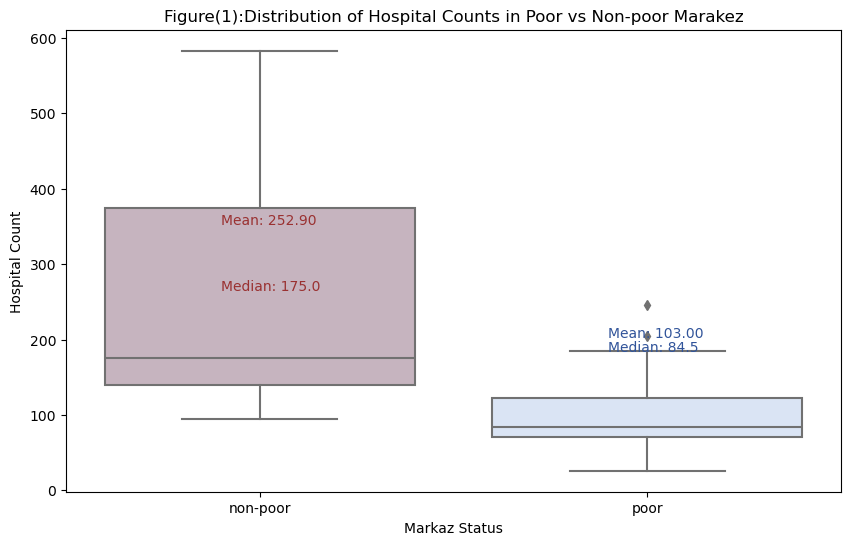

In [88]:
plt.figure(figsize=(10, 6))
custom_palette = ["#C9B1BF", "#D6E3F8"] 
# Calculate the median and mean for each markaz type
median_poor = df_hospital[df_hospital['poor']]['Count'].median()
median_rich = df_hospital[~df_hospital['poor']]['Count'].median()
mean_poor = df_hospital[df_hospital['poor']]['Count'].mean()
mean_rich = df_hospital[~df_hospital['poor']]['Count'].mean()

# Add text annotations for median and mean
plt.text(x=0.9, y=median_poor + 100, s=f'Median: {median_poor}', color='#31549A')
plt.text(x=0.9, y=mean_poor + 100, s=f'Mean: {mean_poor:.2f}', color='#31549A')
plt.text(x=-0.1, y=median_rich + 90, s=f'Median: {median_rich}', color="#9A3131")
plt.text(x=-0.1, y=mean_rich + 100, s=f'Mean: {mean_rich:.2f}', color="#9A3131")

sns.boxplot(x='poor', y='Count', data=df_hospital, palette=custom_palette)

plt.xlabel('Markaz Status')
plt.xticks(ticks=[0, 1], labels=['non-poor', 'poor'])
plt.ylabel('Hospital Count')
plt.title('Figure(1):Distribution of Hospital Counts in Poor vs Non-poor Marakez')
plt.show()

In [89]:
# T-test for hospitals in the poorest marakez vs. hospitals in the rest of the marakez
poor_counts = df_hospital[df_hospital['poor']]['Count']
rich_counts = df_hospital[~df_hospital['poor']]['Count']
# ttest, assumes normality
print(stats.ttest_ind(poor_counts, rich_counts))
#print(stats.ttest_rel(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))

# MannWhitney Test; no assumption of normality + assuming indepndent samples
print(stats.mannwhitneyu(poor_counts, rich_counts)) #Probably more reliable
print(stats.mannwhitneyu(poor_counts, rich_counts, alternative='less')) #Probably more reliable

# Wilcoxon; no assumption of normality + assuming related samples
# print(stats.wilcoxon(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))
# print(stats.wilcoxon(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count'], alternative='less'))


TtestResult(statistic=-3.4280165168575776, pvalue=0.0020356048945712156, df=26.0)
MannwhitneyuResult(statistic=25.0, pvalue=0.0019816980700907115)
MannwhitneyuResult(statistic=25.0, pvalue=0.0009908490350453557)


In [ ]:
df_hospital[df_hospital['poor']]['Count'].describe()

In [90]:
df_hospital[~df_hospital['poor']]['Count'].describe()

count     10.000000
mean     252.900000
std      170.591422
min       94.000000
25%      139.250000
50%      175.000000
75%      374.000000
max      583.000000
Name: Count, dtype: float64

In [91]:
df_hospital[df_hospital['poor']]['Count']

0      89
1      26
2      81
3      48
6      65
7     246
8     143
10     97
12    126
14     74
15     70
18     72
19    185
21    113
22     48
24     88
25    205
27     78
Name: Count, dtype: int64

### Section 3.2.2 : Schools

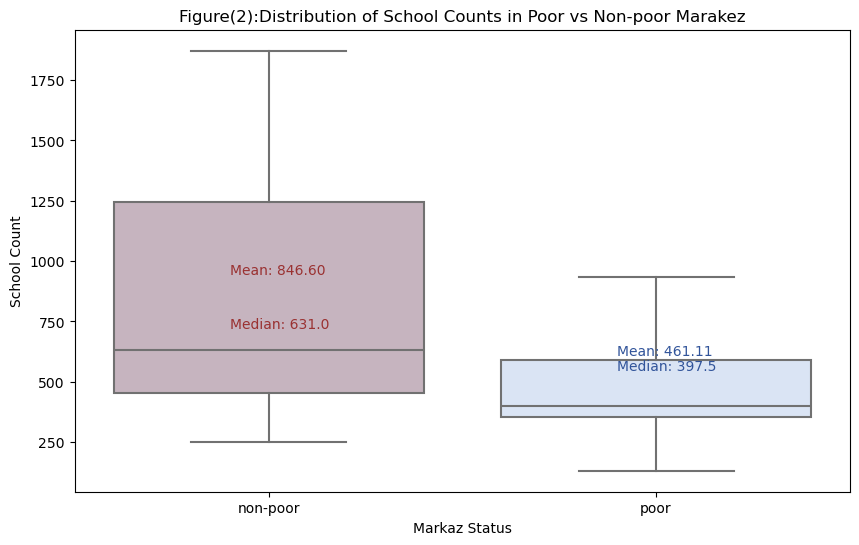

In [92]:
# Calculate the median and mean for each markaz type
median_poor = df_school[df_school['poor']]['Count'].median()
median_rich = df_school[~df_school['poor']]['Count'].median()
mean_poor = df_school[df_school['poor']]['Count'].mean()
mean_rich = df_school[~df_school['poor']]['Count'].mean()

plt.figure(figsize=(10, 6))
custom_palette = ["#C9B1BF", "#D6E3F8"] 

# Add text annotations for median and mean
plt.text(x=0.9, y=median_poor + 150, s=f'Median: {median_poor}', color='#31549A')
plt.text(x=0.9, y=mean_poor + 150, s=f'Mean: {mean_poor:.2f}', color='#31549A')
plt.text(x=-0.1, y=median_rich + 90, s=f'Median: {median_rich}', color="#9A3131")
plt.text(x=-0.1, y=mean_rich + 100, s=f'Mean: {mean_rich:.2f}', color="#9A3131")

sns.boxplot(x='poor', y='Count', data=df_school, palette=custom_palette)

plt.xlabel('Markaz Status')
plt.xticks(ticks=[0, 1], labels=['non-poor', 'poor'])
plt.ylabel('School Count')
plt.title('Figure(2):Distribution of School Counts in Poor vs Non-poor Marakez')
plt.show()


In [ ]:
# T-test for schools in the poorest marakez vs. hospitals in the rest of the marakez
poor_counts = df_school[df_school['poor']]['Count']
rich_counts = df_school[~df_school['poor']]['Count']
# ttest, assumes normality
print(stats.ttest_ind(poor_counts, rich_counts))
#print(stats.ttest_rel(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))

# MannWhitney Test; no assumption of normality + assuming indepndent samples
print(stats.mannwhitneyu(poor_counts, rich_counts)) #Probably more reliable
print(stats.mannwhitneyu(poor_counts, rich_counts, alternative='less')) #Probably more reliable


### Section 3.2.3 : Tamween


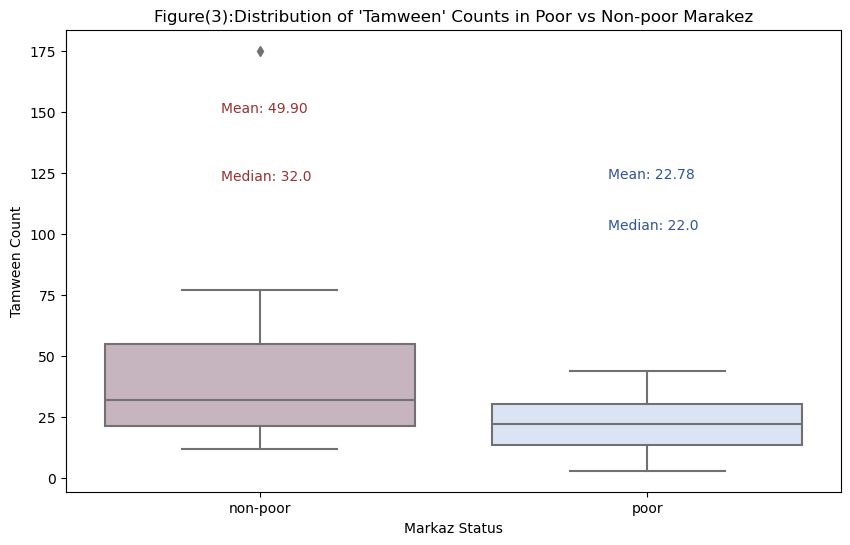

In [93]:
# Calculate the median and mean for each markaz type
median_poor = df_subsidized[df_subsidized['poor']]['Count'].median()
median_rich = df_subsidized[~df_subsidized['poor']]['Count'].median()
mean_poor = df_subsidized[df_subsidized['poor']]['Count'].mean()
mean_rich = df_subsidized[~df_subsidized['poor']]['Count'].mean()

plt.figure(figsize=(10, 6))
custom_palette = ["#C9B1BF", "#D6E3F8"] 

# Add text annotations for median and mean
plt.text(x=0.9, y=median_poor + 80, s=f'Median: {median_poor}', color='#31549A')
plt.text(x=0.9, y=mean_poor + 100, s=f'Mean: {mean_poor:.2f}', color='#31549A')
plt.text(x=-0.1, y=median_rich + 90, s=f'Median: {median_rich}', color="#9A3131")
plt.text(x=-0.1, y=mean_rich + 100, s=f'Mean: {mean_rich:.2f}', color="#9A3131")

sns.boxplot(x='poor', y='Count', data=df_subsidized, palette=custom_palette)

plt.xlabel('Markaz Status')
plt.xticks(ticks=[0, 1], labels=['non-poor', 'poor'])
plt.ylabel('Tamween Count')
plt.title('Figure(3):Distribution of \'Tamween\' Counts in Poor vs Non-poor Marakez')
plt.show()

In [ ]:
# T-test for tamween in the poorest marakez vs. hospitals in the rest of the marakez
poor_counts = df_subsidized[df_subsidized['poor']]['Count']
rich_counts = df_subsidized[~df_subsidized['poor']]['Count']
# ttest, assumes normality
print(stats.ttest_ind(poor_counts, rich_counts))
#print(stats.ttest_rel(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))

# MannWhitney Test; no assumption of normality + assuming indepndent samples
print(stats.mannwhitneyu(poor_counts, rich_counts)) #Probably more reliable
print(stats.mannwhitneyu(poor_counts, rich_counts, alternative='less')) #Probably more reliable

### Section 3.2.4 : Youth Centers

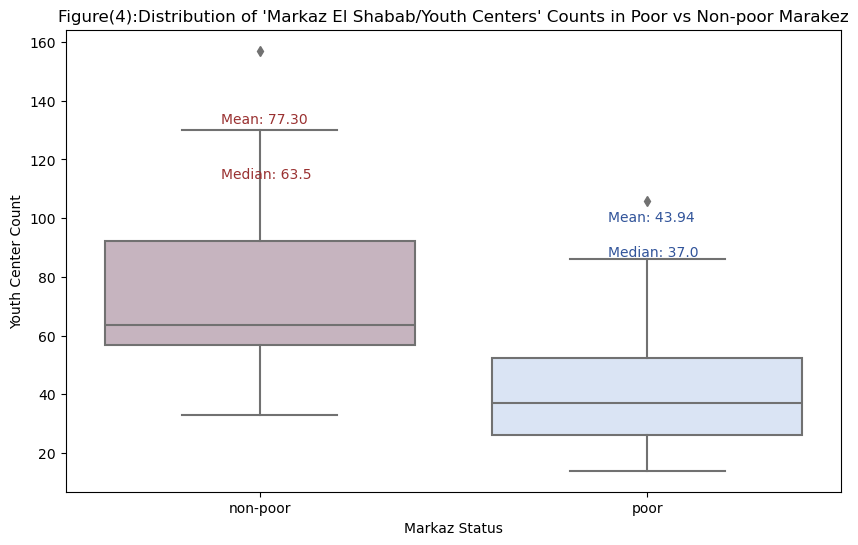

In [94]:
# Calculate the median and mean for each markaz type
median_poor = df_youth_center[df_youth_center['poor']]['Count'].median()
median_rich = df_youth_center[~df_youth_center['poor']]['Count'].median()
mean_poor = df_youth_center[df_youth_center['poor']]['Count'].mean()
mean_rich = df_youth_center[~df_youth_center['poor']]['Count'].mean()

plt.figure(figsize=(10, 6))
custom_palette = ["#C9B1BF", "#D6E3F8"] 

# Add text annotations for median and mean
plt.text(x=0.9, y=median_poor + 50, s=f'Median: {median_poor}', color='#31549A')
plt.text(x=0.9, y=mean_poor + 55, s=f'Mean: {mean_poor:.2f}', color='#31549A')
plt.text(x=-0.1, y=median_rich + 50, s=f'Median: {median_rich}', color="#9A3131")
plt.text(x=-0.1, y=mean_rich + 55, s=f'Mean: {mean_rich:.2f}', color="#9A3131")

sns.boxplot(x='poor', y='Count', data=df_youth_center, palette=custom_palette)

plt.xlabel('Markaz Status')
plt.xticks(ticks=[0, 1], labels=['non-poor', 'poor'])
plt.ylabel('Youth Center Count')
plt.title('Figure(4):Distribution of \'Markaz El Shabab/Youth Centers\' Counts in Poor vs Non-poor Marakez')
plt.show()

In [95]:
# T-test for youth centers in the poorest marakez vs. hospitals in the rest of the marakez
poor_counts = df_youth_center[df_youth_center['poor']]['Count']
rich_counts = df_youth_center[~df_youth_center['poor']]['Count']
# ttest, assumes normality
print(stats.ttest_ind(poor_counts, rich_counts))
#print(stats.ttest_rel(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))

# MannWhitney Test; no assumption of normality + assuming indepndent samples
print(stats.mannwhitneyu(poor_counts, rich_counts)) #Probably more reliable
print(stats.mannwhitneyu(poor_counts, rich_counts, alternative='less')) #Probably more reliable

TtestResult(statistic=-2.7053155130325273, pvalue=0.011882176829387978, df=26.0)
MannwhitneyuResult(statistic=37.0, pvalue=0.011771997483227811)
MannwhitneyuResult(statistic=37.0, pvalue=0.005885998741613906)


### Section 3.2.5 :  Retail Outlets

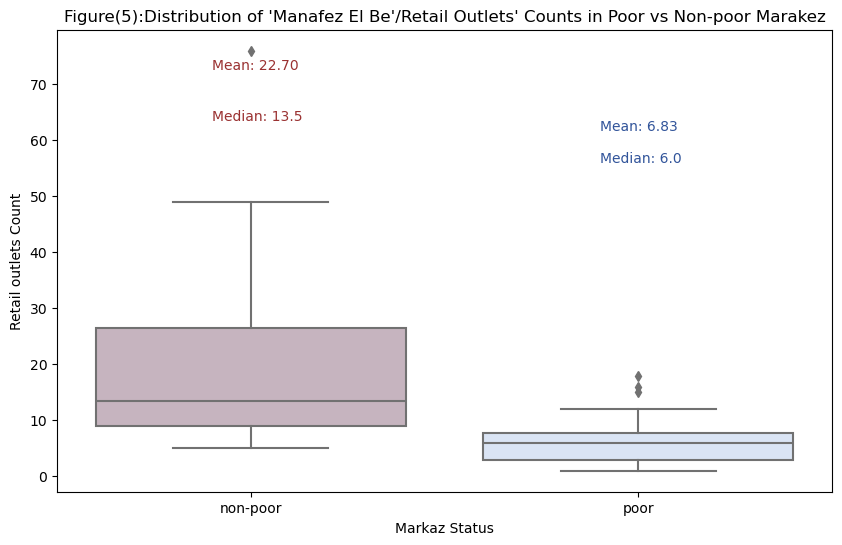

In [96]:
# Calculate the median and mean for each markaz type
median_poor = df_retail_outlet[df_retail_outlet['poor']]['Count'].median()
median_rich = df_retail_outlet[~df_retail_outlet['poor']]['Count'].median()
mean_poor = df_retail_outlet[df_retail_outlet['poor']]['Count'].mean()
mean_rich = df_retail_outlet[~df_retail_outlet['poor']]['Count'].mean()

plt.figure(figsize=(10, 6))
custom_palette = ["#C9B1BF", "#D6E3F8"] 

# Add text annotations for median and mean
plt.text(x=0.9, y=median_poor + 50, s=f'Median: {median_poor}', color='#31549A')
plt.text(x=0.9, y=mean_poor + 55, s=f'Mean: {mean_poor:.2f}', color='#31549A')
plt.text(x=-0.1, y=median_rich + 50, s=f'Median: {median_rich}', color="#9A3131")
plt.text(x=-0.1, y=mean_rich + 50, s=f'Mean: {mean_rich:.2f}', color="#9A3131")

sns.boxplot(x='poor', y='Count', data=df_retail_outlet, palette=custom_palette)

plt.xlabel('Markaz Status')
plt.xticks(ticks=[0, 1], labels=['non-poor', 'poor'])
plt.ylabel('Retail outlets Count')
plt.title('Figure(5):Distribution of \'Manafez El Be\'/Retail Outlets\' Counts in Poor vs Non-poor Marakez')
plt.show()

In [97]:
# T-test for retail outlets in the poorest marakez vs. hospitals in the rest of the marakez
poor_counts = df_retail_outlet[df_retail_outlet['poor']]['Count']
rich_counts = df_retail_outlet[~df_retail_outlet['poor']]['Count']
# ttest, assumes normality
print(stats.ttest_ind(poor_counts, rich_counts))
#print(stats.ttest_rel(df_hospital[df_hospital['poor']]['Count'], df_hospital[~df_hospital['poor']]['Count']))

# MannWhitney Test; no assumption of normality + assuming indepndent samples
print(stats.mannwhitneyu(poor_counts, rich_counts)) #Probably more reliable
print(stats.mannwhitneyu(poor_counts, rich_counts, alternative='less')) #Probably more reliable

TtestResult(statistic=-2.836311031678375, pvalue=0.008723643143247918, df=26.0)
MannwhitneyuResult(statistic=34.0, pvalue=0.007606195498668297)
MannwhitneyuResult(statistic=34.0, pvalue=0.0038030977493341486)
